In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the dataset

In [4]:
x_train = pd.read_csv('/content/drive/MyDrive/Project/US Adidas Sales/Dataset/x_train_oper_clean.csv')
x_test = pd.read_csv('/content/drive/MyDrive/Project/US Adidas Sales/Dataset/x_test_oper_clean.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Project/US Adidas Sales/Dataset/y_train_operating_margin.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Project/US Adidas Sales/Dataset/y_test_operating_margin.csv')

In [5]:
y_test1 = y_test["Operating Margin"]
y_train1 = y_train["Operating Margin"]

In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.1 MB/s eta 0:00:00


In [7]:
import shap

In [46]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.3 MB/s eta 0:00:00


In [47]:
import optuna

In [58]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.4 MB/s eta 0:00:00


Getter function for adjusted R-squared

In [9]:
def adj_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - n_features - 1)
    return adj_r2

1) Random Forest Baseline

In [11]:
print("--------RF--------")
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# create and fit the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(x_train, y_train1)

# predict on the test set
y_pred = rf_reg.predict(x_test)

# evaluate the model using mean squared error
mse = mean_squared_error(y_test1, y_pred)

# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test, y_pred, x_test.shape[1])
print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------RF--------
Mean Squared Error: 12.6516875399361
Adjusted R^2: 0.8505684320942557


Feature Importance for the Random Forest

                     Feature  Importance
4                 Units Sold    0.203096
17       Sales Method_Online    0.177367
13              Region_South    0.066516
2                     Gender    0.061544
3             Price per Unit    0.059208
1                        Day    0.055708
19          Product_ Apparel    0.047103
0                      Month    0.032302
21  Product_ Street Footwear    0.028187
31              State_Hawaii    0.025861


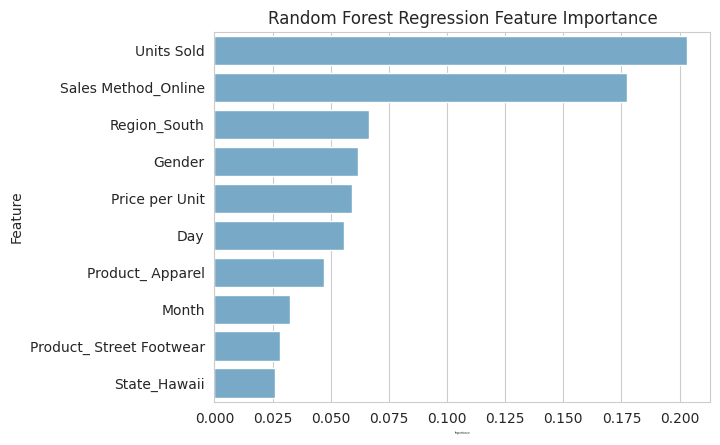

In [12]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = rf_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('Random Forest Regression Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply plot for the Random Forest

Permutation explainer: 201it [00:58,  3.06it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


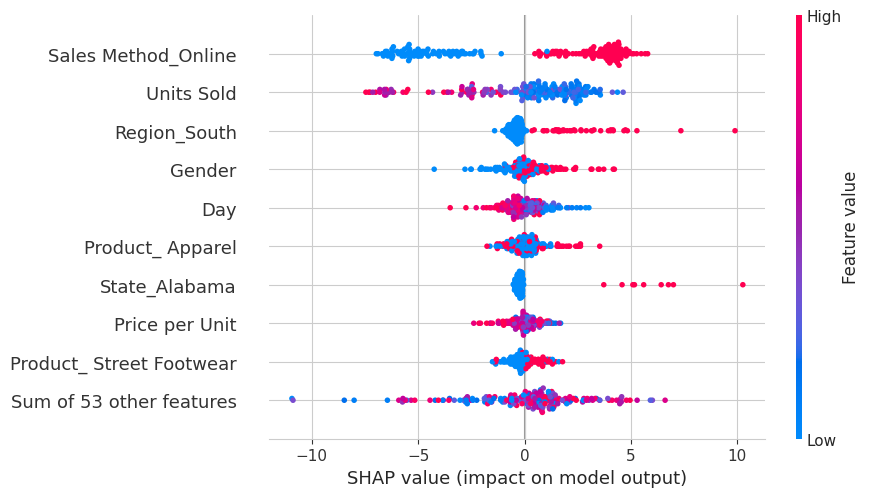

In [13]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(rf_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

2) LGBM

In [14]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Month                       5842 non-null   int64  
 1   Day                         5842 non-null   int64  
 2   Gender                      5842 non-null   int64  
 3   Price per Unit              5842 non-null   float64
 4   Units Sold                  5842 non-null   int64  
 5   Retailer_Amazon             5842 non-null   int64  
 6   Retailer_Foot Locker        5842 non-null   int64  
 7   Retailer_Kohl's             5842 non-null   int64  
 8   Retailer_Sports Direct      5842 non-null   int64  
 9   Retailer_Walmart            5842 non-null   int64  
 10  Retailer_West Gear          5842 non-null   int64  
 11  Region_Midwest              5842 non-null   int64  
 12  Region_Northeast            5842 non-null   int64  
 13  Region_South                5842 

In [28]:
print("--------LGBM--------")
import lightgbm as lgb
# Create a LightGBM regressor
lgb_regressor = lgb.LGBMRegressor(random_state = 42)
cat_features_index = [i for i in range(len(x_train.columns)) if i not in [3, 4] and x_train.dtypes[i] == 'int64']
# Train the regressor
lgb_regressor.fit(x_train, y_train,categorical_feature=cat_features_index)

# Make predictions on the test data
y_pred1 = lgb_regressor.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred1)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred1, x_test.shape[1])

print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------LGBM--------


Using categorical_feature in Dataset.


Mean Squared Error: 18.253294622193508
Adjusted R^2: 0.7844067499904726


Feature Importance for LGBM

                       Feature  Importance
4                   Units Sold         382
2                       Gender         375
19            Product_ Apparel         285
1                          Day         262
3               Price per Unit         261
0                        Month         118
21    Product_ Street Footwear          93
20  Product_ Athletic Footwear          88
26            State_California          71
11              Region_Midwest          54


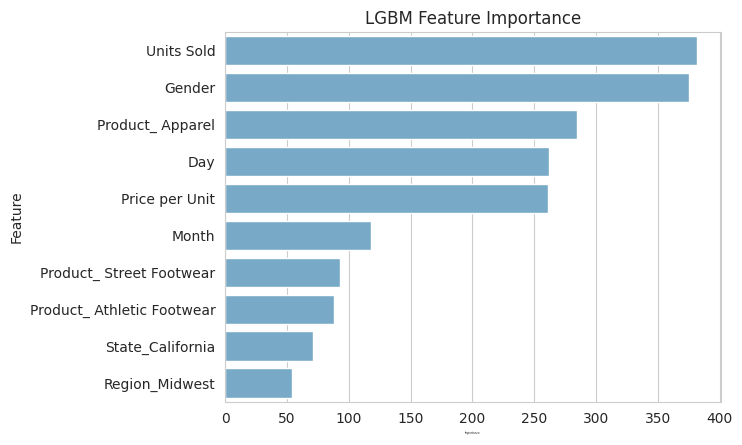

In [29]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = lgb_regressor.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('LGBM Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply Plot for LGBM

Permutation explainer: 201it [00:31,  4.28it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


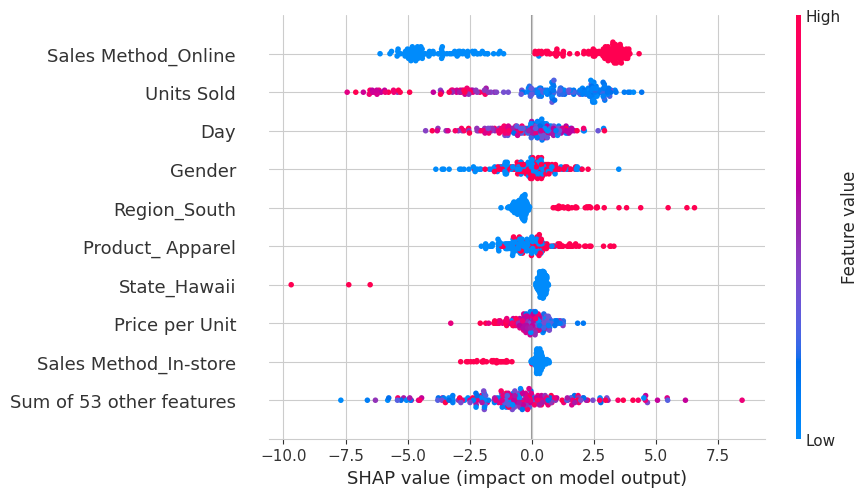

In [30]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(lgb_regressor.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

3) XGBOOST

In [34]:
import xgboost as xgb
print("--------XGBoost--------")
# Instantiate an XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state = 42)

# Train the model on the training data
xgb_reg.fit(x_train, y_train)

# Predict the target values for the test data
y_pred2 = xgb_reg.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred2)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred2, x_test.shape[1])

print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------XGBoost--------
Mean Squared Error: 10.176048925814252
Adjusted R^2: 0.8798086862902663


Feature Importance for XGBoost

                Feature  Importance
17  Sales Method_Online    0.177350
13         Region_South    0.146184
31         State_Hawaii    0.104981
22        State_Alabama    0.052124
54   State_South Dakota    0.034397
39  State_Massachusetts    0.030235
23         State_Alaska    0.024406
26     State_California    0.017528
9      Retailer_Walmart    0.016284
29        State_Florida    0.016251


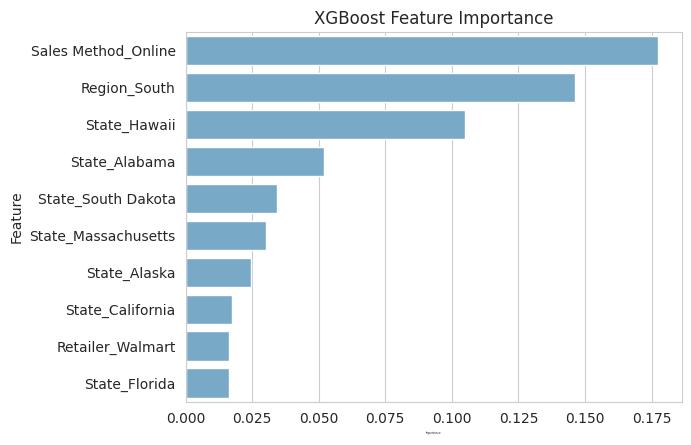

In [35]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = xgb_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply plot for XGBoost

Permutation explainer: 201it [00:15,  4.77it/s]                         


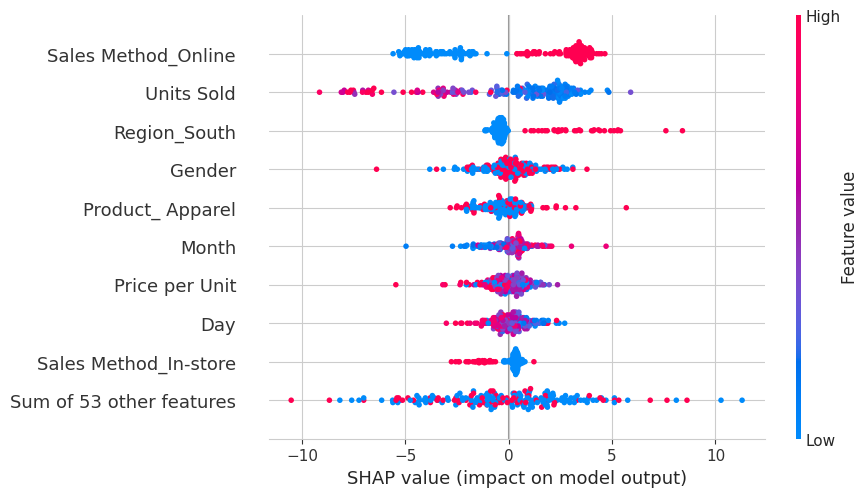

In [37]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(xgb_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

4) Elastic Net

In [44]:
from sklearn.linear_model import ElasticNet
print("--------Elastic Net--------")

# Fit an Elastic Net regression model on the training data
enet = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42)
enet.fit(x_train, y_train1)

# Make predictions on the test set
y_pred3 = enet.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred3)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred3, x_test.shape[1])

print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------Elastic Net--------
Mean Squared Error: 67.38338433397676
Adjusted R^2: 0.20412160511890298


The results are quite bad, we will use some form of tuning to get the best results.

In [55]:
# Define the objective function
def objective(trial):

    # Define the hyperparameters to tune
    alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

    # Initialize the Elastic Net model with the hyperparameters
    en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)

    # Fit the model on the training data
    en.fit(x_train, y_train)

    # Predict on the validation data
    y_pred = en.predict(x_test)

    # Calculate the mean squared error and adjusted R-squared on the validation data
    mse = mean_squared_error(y_test, y_pred)
    
    # Return the evaluation metrics to optimize
    return mse
# Define the study object and optimize the objective function
study = optuna.create_study(direction='minimize', study_name = 'regression')
study.optimize(objective, n_trials=1000)

# Print the best hyperparameters and evaluation metrics
print('Best Hyperparameters:', study.best_params)


[I 2023-05-11 16:17:39,599] A new study created in memory with name: regression
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+03, tolerance: 5.267e+01
[I 2023-05-11 16:17:40,586] Trial 0 finished with value: 49.89252055151801 and parameters: {'alpha': 0.0007720521839769349, 'l1_ratio': 0.7124960865618513}. Best is trial 0 with value: 49.89252055151801.
[I 2023-05-11 16:17:40,794] Trial 1 finished with value: 50.028412805121555 and parameters: {'alpha': 0.007608106486831249, 'l1_ratio': 0.42756451990728284}. Best is trial 0 with value: 49.89252055151801.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+04, tolerance: 5.267e+01
[I 2023-05-11 16:17:41,613] Trial 2 finished with value: 49.93130948475472 and parameters: {'alpha': 5.8120017255761e

Best Hyperparameters: {'alpha': 0.003581523919303601, 'l1_ratio': 0.641369089344304}


In [56]:
# Fit an Elastic Net regression model on the training data
enet = ElasticNet(alpha=0.003581523919303601,
                  l1_ratio=0.641369089344304,
                  random_state=42)
enet.fit(x_train, y_train1)

# Make predictions on the test set
y_pred3 = enet.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred3)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred3, x_test.shape[1])

print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

Mean Squared Error: 49.81523415026173
Adjusted R^2: 0.41162247951762276


5) Catboost

In [60]:
from catboost import CatBoostRegressor
print("--------CatBoost--------")

# Initialize the CatBoostRegressor model
cat_reg = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6,
                            random_seed=42, loss_function='RMSE')

# Fit the model on the training data
cat_reg.fit(x_train, y_train1, verbose = False)

# Predict on the validation data
y_pred4 = cat_reg.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred4)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred4, x_test.shape[1])

print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------CatBoost--------
Mean Squared Error: 5.747574915681782
Adjusted R^2: 0.9321142631293285


Feature importance for CatBoost

                     Feature  Importance
2                     Gender   15.436469
17       Sales Method_Online   11.842816
4                 Units Sold   10.969953
19          Product_ Apparel   10.338895
1                        Day    5.495793
13              Region_South    4.752816
26          State_California    4.252781
21  Product_ Street Footwear    3.439456
3             Price per Unit    2.710661
0                      Month    2.704353


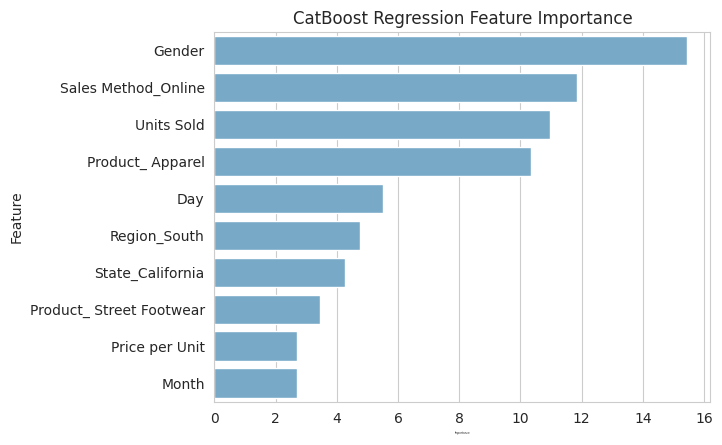

In [61]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = cat_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('CatBoost Regression Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply Plot

Permutation explainer: 201it [00:15,  5.25it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


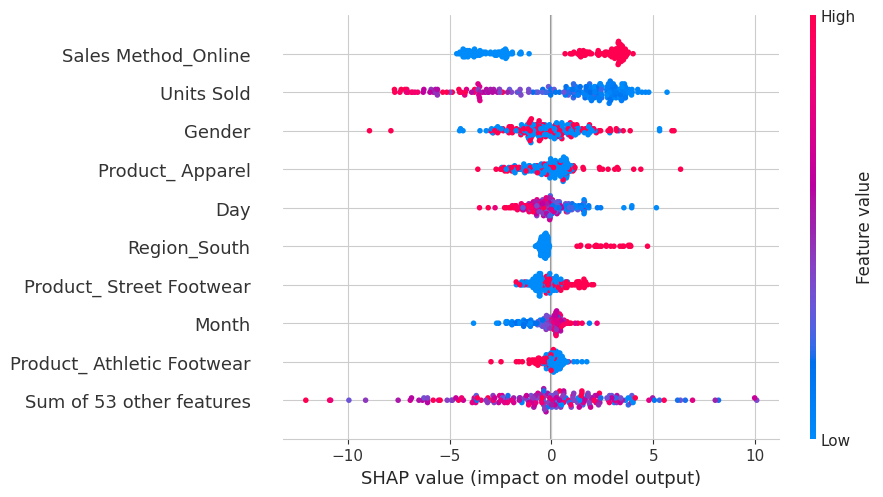

In [62]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(cat_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)